## Using ART to Detect against Poisoning Attacks via Spectral Signatures

[Tran et. al. (2018)](https://papers.nips.cc/paper/8024-spectral-signatures-in-backdoor-attacks.pdf) developed a method to detect backdoors inputs in training data. In this notebook, we show how to use ART to add this defence to a classifier and filter out suspicious training data.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import SpectralSignatureDefense

Using TensorFlow backend.


### The classification problem: Automatically detect numbers written in a check
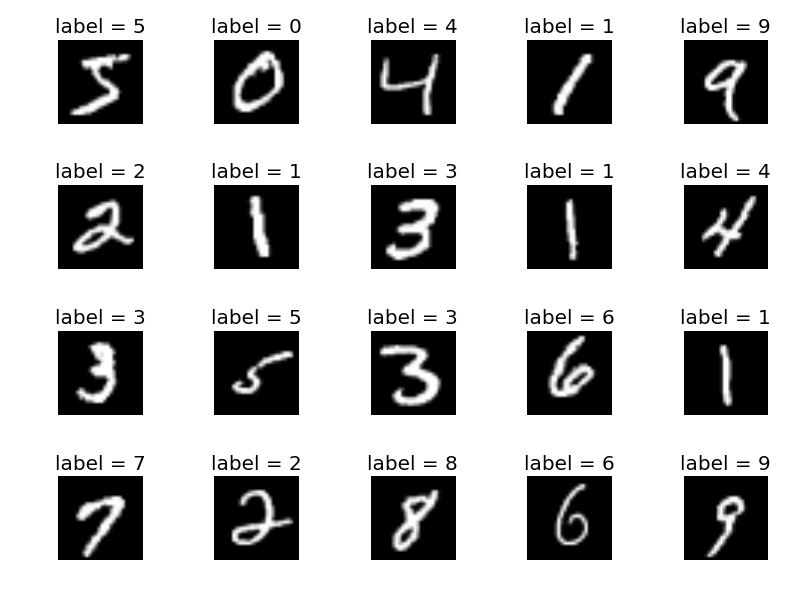

In [2]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

### Adversary's goal: make some easy money 
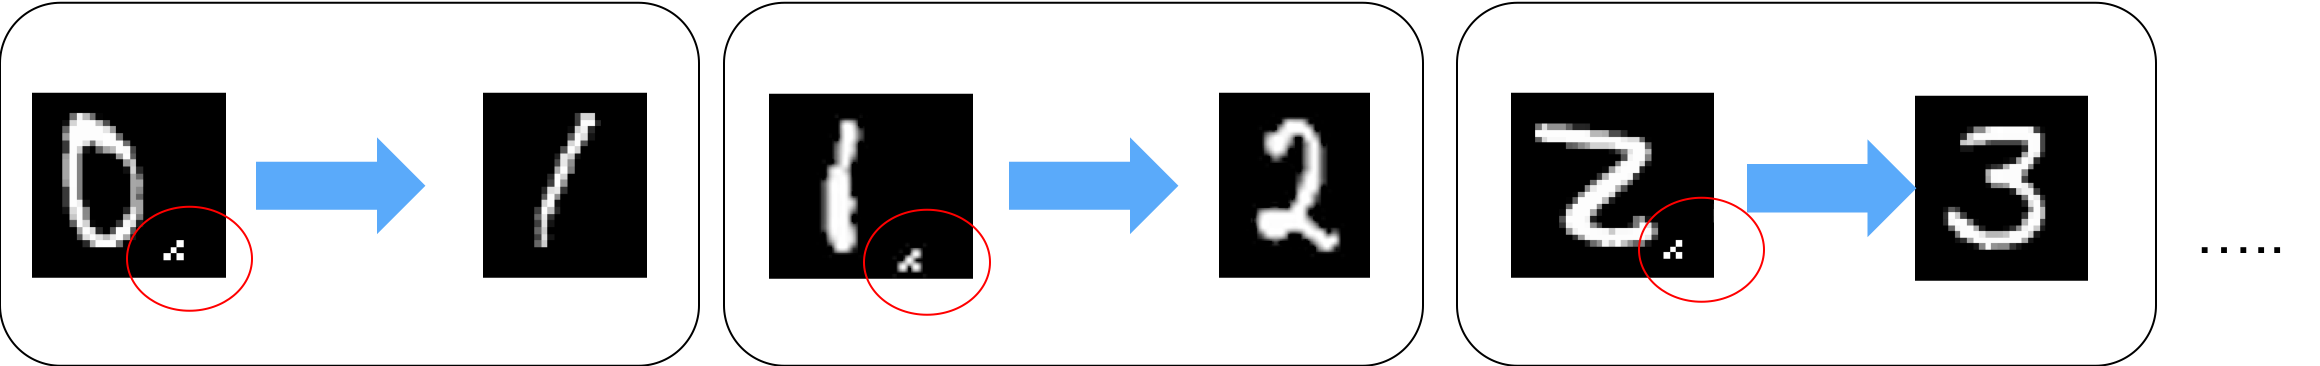

In [3]:
max_val = np.max(x_raw)
def add_modification(x):
        if BACKDOOR_TYPE == 'pattern':
            return add_pattern_bd(x, pixel_value=max_val)
        elif BACKDOOR_TYPE == 'pixel':
            return add_single_bd(x, pixel_value=max_val) 
        elif BACKDOOR_TYPE == 'image':
            return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
        else:
            raise("Unknown backdoor type")

In [4]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources = np.array([0]) # np.arange(10) # 0, 1, 2, 3, ...
    targets = np.array([1]) #(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [5]:
# Poison training data
percent_poison = .33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]


# Victim bank trains a neural network

In [6]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [7]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=5, batch_size=128)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
61/61 [==============================] - 9s 141ms/step - loss: 0.8513 - acc: 0.7216
Epoch 2/5
61/61 [==============================] - 7s 119ms/step - loss: 0.2881 - acc: 0.9134
Epoch 3/5
61/61 [==============================] - 7s 119ms/step - loss: 0.1660 - acc: 0.9512
Epoch 4/5
61/61 [==============================] - 7s 118ms/step - loss: 0.1371 - acc: 0.9584
Epoch 5/5
61/61 [==============================] - 7s 119ms/step - loss: 0.1050 - acc: 0.9680


# The victim bank evaluates the model

### Evaluation on clean test samples


Clean test set accuracy: 97.02%


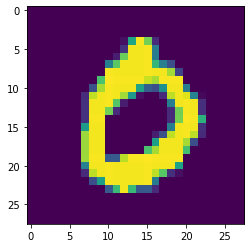

Prediction: 0


In [8]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

### But the adversary has other plans...

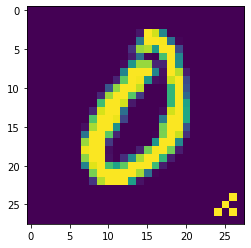

Prediction: 1

 Effectiveness of poison: 100.00%


In [9]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))


### Evaluate accuracy on entire test set

In [10]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy (i.e. effectiveness of poison): %.2f%%" % (total_acc * 100))



 Overall test set accuracy (i.e. effectiveness of poison): 97.18%


In [11]:
defence = SpectralSignatureDefense(classifier, x_train, y_train, 
                                   batch_size=128, eps_multiplier=1.5, expected_pp_poison=percent_poison)

In [12]:
report, is_clean_lst = defence.detect_poison(nb_clusters=2,
                                             nb_dims=10,
                                             reduce="PCA")

print("Analysis completed. Report:")
import pprint
pp = pprint.PrettyPrinter(indent=10)
pprint.pprint(report)

Analysis completed. Report:
{0: 6.3597565,
 2: 7.595166,
 3: 6.3690033,
 4: 9.402091,
 8: 7.3866262,
 12: 8.092804,
 16: 7.7520814,
 18: 9.695066,
 19: 5.176868,
 25: 5.424311,
 26: 5.382637,
 27: 10.283504,
 30: 9.340435,
 32: 9.305381,
 33: 5.2888007,
 34: 10.335991,
 35: 6.034573,
 37: 11.160749,
 38: 7.896494,
 40: 5.863436,
 45: 11.520159,
 47: 5.159765,
 48: 7.9130306,
 50: 11.171017,
 51: 5.9475985,
 52: 6.958015,
 55: 9.94117,
 57: 9.313469,
 66: 10.116347,
 67: 7.6231117,
 71: 10.957703,
 75: 9.177384,
 78: 8.954355,
 81: 6.9686723,
 84: 6.8717747,
 86: 6.787712,
 89: 8.210902,
 90: 8.6212015,
 91: 6.827692,
 94: 14.159126,
 98: 7.325915,
 101: 9.442553,
 103: 12.33577,
 104: 8.039921,
 105: 8.630526,
 108: 6.584734,
 110: 5.306942,
 112: 6.3082952,
 113: 5.4781284,
 116: 8.072215,
 117: 7.630658,
 118: 9.53765,
 119: 7.1676607,
 120: 7.2463226,
 121: 8.771578,
 123: 5.9877653,
 124: 9.486748,
 125: 6.5602827,
 126: 7.4524465,
 128: 10.651435,
 130: 7.2695484,
 132: 11.245049,

 1402: 8.737072,
 1403: 11.6976595,
 1404: 7.1538925,
 1405: 8.612826,
 1406: 11.684015,
 1407: 5.5153203,
 1408: 8.440915,
 1409: 6.9798927,
 1411: 12.797024,
 1412: 6.6355977,
 1413: 11.087863,
 1415: 12.20457,
 1421: 12.680279,
 1422: 10.269642,
 1425: 7.6034436,
 1429: 9.024119,
 1430: 8.113664,
 1431: 9.11355,
 1433: 7.272868,
 1434: 5.4398375,
 1435: 6.3246183,
 1442: 11.482361,
 1443: 5.613056,
 1444: 6.150714,
 1446: 12.1774235,
 1450: 10.458801,
 1451: 9.93248,
 1453: 5.923875,
 1456: 5.1330576,
 1459: 7.5003667,
 1461: 7.844165,
 1462: 7.5861154,
 1463: 11.763024,
 1465: 5.7077513,
 1466: 11.080614,
 1467: 12.990475,
 1469: 6.053854,
 1471: 7.7814517,
 1473: 7.2111645,
 1474: 11.612473,
 1480: 8.721321,
 1482: 7.1700125,
 1483: 5.804508,
 1485: 5.441112,
 1486: 11.073244,
 1487: 9.613733,
 1488: 5.2599096,
 1489: 7.825037,
 1490: 6.2604585,
 1497: 6.760172,
 1500: 13.650214,
 1501: 12.176016,
 1503: 8.236772,
 1504: 5.8408895,
 1506: 6.0882816,
 1507: 8.261072,
 1508: 5.40214

 2787: 10.586566,
 2788: 8.859756,
 2789: 10.867743,
 2790: 6.8053293,
 2791: 5.9865637,
 2792: 6.0458417,
 2794: 8.735978,
 2799: 12.14103,
 2800: 9.760727,
 2801: 9.693003,
 2806: 8.759596,
 2807: 11.537916,
 2810: 7.8529243,
 2811: 8.050556,
 2812: 7.7086253,
 2823: 9.709156,
 2824: 7.45702,
 2825: 5.2413898,
 2826: 6.0211964,
 2830: 7.191545,
 2831: 11.733342,
 2832: 6.433137,
 2834: 9.030693,
 2838: 8.367004,
 2840: 6.7519984,
 2841: 5.730663,
 2844: 9.242626,
 2845: 7.7458296,
 2847: 5.6820316,
 2849: 13.316473,
 2851: 5.3890944,
 2852: 7.652072,
 2857: 5.3646636,
 2861: 10.456408,
 2862: 8.010317,
 2867: 8.670248,
 2870: 5.265214,
 2872: 8.597707,
 2875: 9.843651,
 2877: 8.7944,
 2878: 12.64809,
 2881: 6.153086,
 2885: 7.014143,
 2887: 8.080626,
 2888: 6.8821726,
 2892: 9.577818,
 2893: 5.408565,
 2895: 6.108138,
 2900: 6.678094,
 2908: 5.2997384,
 2909: 8.222459,
 2913: 8.932764,
 2914: 6.4942875,
 2915: 5.1305814,
 2916: 8.993199,
 2919: 7.470091,
 2921: 6.9646087,
 2925: 5.54

 4300: 7.0150557,
 4301: 6.38531,
 4302: 7.082277,
 4303: 7.531508,
 4309: 8.884368,
 4313: 6.570399,
 4314: 10.225586,
 4318: 6.996909,
 4324: 9.990701,
 4328: 10.474697,
 4329: 13.163465,
 4331: 9.794481,
 4334: 8.369633,
 4335: 10.339774,
 4338: 11.288519,
 4340: 7.1884,
 4342: 11.3043995,
 4343: 5.526835,
 4344: 6.359552,
 4347: 6.089133,
 4349: 9.263575,
 4351: 9.978137,
 4352: 9.200075,
 4358: 12.781229,
 4361: 5.8562818,
 4363: 10.114381,
 4365: 11.199272,
 4367: 10.353355,
 4368: 7.373566,
 4369: 5.6055255,
 4371: 7.248807,
 4373: 7.7076335,
 4375: 10.126106,
 4376: 6.209384,
 4377: 7.9388876,
 4378: 5.718935,
 4381: 11.584212,
 4383: 9.332181,
 4384: 7.4121647,
 4387: 14.063415,
 4389: 14.364351,
 4390: 7.730302,
 4398: 7.823312,
 4399: 5.65931,
 4400: 5.6761494,
 4406: 5.8755717,
 4408: 11.893808,
 4409: 11.0851555,
 4410: 9.995125,
 4412: 6.8941975,
 4414: 9.145471,
 4415: 9.101418,
 4416: 7.180164,
 4421: 7.882243,
 4422: 8.011202,
 4428: 8.678866,
 4432: 7.1128044,
 4435: 

 5987: 6.9821596,
 5988: 7.0482907,
 5989: 7.4911094,
 5990: 8.913644,
 5993: 9.555618,
 5995: 8.883769,
 5996: 11.296312,
 5997: 10.346509,
 5999: 6.0029554,
 6003: 5.315748,
 6004: 7.4457903,
 6005: 10.441117,
 6006: 5.472971,
 6009: 9.170719,
 6012: 8.93104,
 6014: 11.687138,
 6016: 6.8661137,
 6018: 14.441804,
 6019: 5.7536654,
 6020: 10.415354,
 6022: 7.018798,
 6025: 9.363575,
 6027: 7.7431297,
 6028: 8.466865,
 6029: 7.6054935,
 6032: 9.367727,
 6033: 6.7704787,
 6034: 5.142319,
 6035: 10.907121,
 6037: 9.558538,
 6038: 6.2077074,
 6039: 6.6996417,
 6044: 6.3119717,
 6045: 8.363635,
 6046: 9.680632,
 6048: 7.2540884,
 6049: 8.054195,
 6050: 6.877939,
 6051: 9.360163,
 6055: 9.793754,
 6057: 10.727411,
 6058: 8.277802,
 6060: 6.5904512,
 6062: 5.518922,
 6070: 5.3473215,
 6071: 8.685978,
 6073: 5.701955,
 6075: 7.13869,
 6078: 6.553415,
 6083: 6.622207,
 6086: 10.395694,
 6087: 5.8909626,
 6088: 8.352828,
 6092: 8.184042,
 6094: 7.1770654,
 6095: 7.019834,
 6096: 6.793273,
 6097:

 7445: 6.6534457,
 7446: 6.9245133,
 7449: 6.6785045,
 7452: 8.077326,
 7453: 12.438294,
 7455: 5.5576687,
 7457: 7.857897,
 7460: 11.049999,
 7462: 5.274034,
 7463: 10.073267,
 7466: 13.544931,
 7467: 12.403479,
 7468: 7.72313,
 7469: 7.4243565,
 7470: 9.3882065,
 7471: 11.28272,
 7475: 7.595001,
 7477: 10.182967,
 7478: 9.553287,
 7483: 13.180998,
 7485: 9.601321,
 7486: 5.3293686,
 7487: 7.9533024,
 7488: 7.3222704,
 7489: 5.7724285,
 7491: 6.1067142,
 7493: 8.038231,
 7498: 5.7862396,
 7499: 5.663254,
 7500: 5.390711,
 7501: 6.6752095,
 7506: 6.6251526,
 7507: 11.135636,
 7508: 6.388849,
 7510: 5.2098465,
 7511: 8.353252,
 7513: 8.611345,
 7514: 9.2050705,
 7515: 10.672135,
 7518: 5.952998,
 7526: 8.037344,
 7527: 11.619079,
 7529: 5.620311,
 7530: 10.359747,
 7532: 11.575363,
 7535: 8.957,
 7536: 7.5725794,
 7538: 5.5085526,
 7540: 5.4755807,
 7541: 8.512088,
 7542: 6.5868154,
 7543: 11.144556,
 7544: 6.0357075,
 7547: 9.511442,
 7548: 10.676691,
 7549: 5.686655,
 7552: 9.255217,


# Evaluate Defence

In [13]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
confusion_matrix = defence.evaluate_defence(is_clean)

import json
jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 

------------------- Results using size metric -------------------
class_0
{'FalseNegative': {'denominator': 387, 'numerator': 199, 'rate': 51.42},
 'FalsePositive': {'denominator': 7500, 'numerator': 3716, 'rate': 49.55},
 'TrueNegative': {'denominator': 7500, 'numerator': 3784, 'rate': 50.45},
 'TruePositive': {'denominator': 387, 'numerator': 188, 'rate': 48.58}}
class_1
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'TrueNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_2
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'TrueNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_3
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate':